#  Import all libraries

In [1]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\keshav\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

## Data Cleaning, Preprocessing & EDA

In [6]:
df = pd.read_csv("IMDB Dataset.csv")

In [7]:
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (50000, 2)


review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [8]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [40]:
print("Duplicates before:", df.duplicated().sum())


Duplicates before: 418


In [41]:
df.drop_duplicates(inplace=True)
print("Duplicates after:", df.duplicated().sum())

Duplicates after: 418


In [12]:
df['sentiment'].value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

C:\Users\keshav\AppData\Local\Temp\ipykernel_9244\364794251.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='coolwarm')


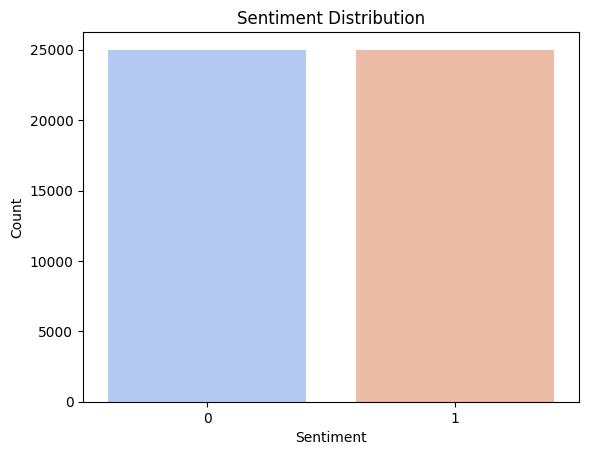

In [37]:
# Sentiment distribution
sns.countplot(data=df, x='sentiment', palette='coolwarm')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
sns
plt.show()

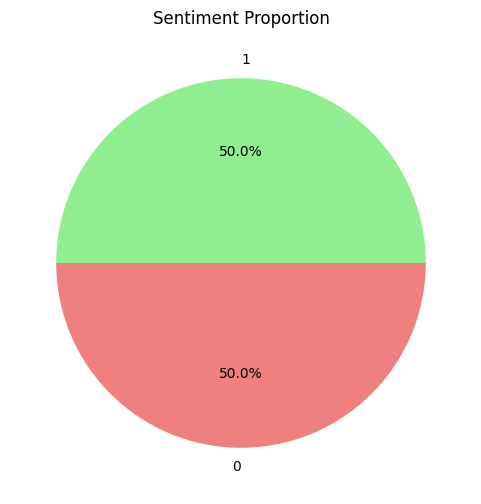

In [44]:
df['sentiment'].value_counts().plot.pie(
    autopct='%1.1f%%', figsize=(6,6), colors=['lightgreen', 'lightcoral']
)
plt.title("Sentiment Proportion")
plt.ylabel("")
plt.show()

In [16]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = str(text).lower()                        # lowercase
    text = re.sub(r'\[.*?\]', '', text)             # remove brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # remove links
    text = re.sub(r'<.*?>+', '', text)              # remove html tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # remove punctuation
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)            # remove numbers
    words = text.split()
    words = [stemmer.stem(w) for w in words if w not in stop_words]
    return " ".join(words)

df['cleaned_text'] = df['review'].apply(clean_text)

In [17]:
# Converting Labels
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

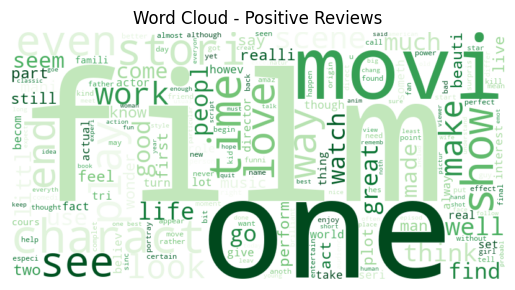

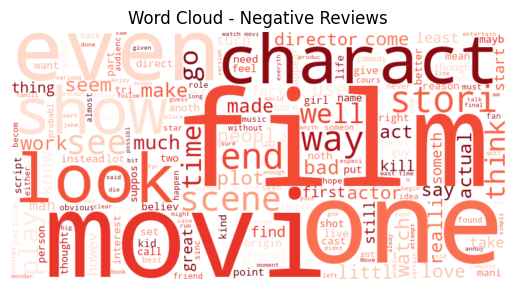

In [43]:
from wordcloud import WordCloud

# Positive reviews
pos_text = " ".join(df[df['sentiment']==1]['cleaned_text'])
wc_pos = WordCloud(width=800, height=400, background_color='white',colormap='Greens').generate(pos_text)
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Positive Reviews")
plt.show()

# Negative reviews
neg_text = " ".join(df[df['sentiment']==0]['cleaned_text'])
wc_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(neg_text)
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Negative Reviews")
plt.show()

# Model Training and Feature Extraction
#### -Feature Extraction using TF-IDF 
#### -Model Training with Logistic Regression

In [18]:
# Split Dataset
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'], df['sentiment'], test_size=0.2, random_state=42)

In [21]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

In [22]:
X_train_tfidf = tfidf.fit_transform(X_train)

In [23]:
X_test_tfidf = tfidf.transform(X_test)

In [24]:
# Train the model
model = LogisticRegression(max_iter=1000)


In [25]:
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [38]:
# Evaluate
y_pred = model.predict(X_test_tfidf)
print("\n Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))


 Accuracy: 0.8851

 Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.88      0.89     10000
weighted avg       0.89      0.89      0.89     10000



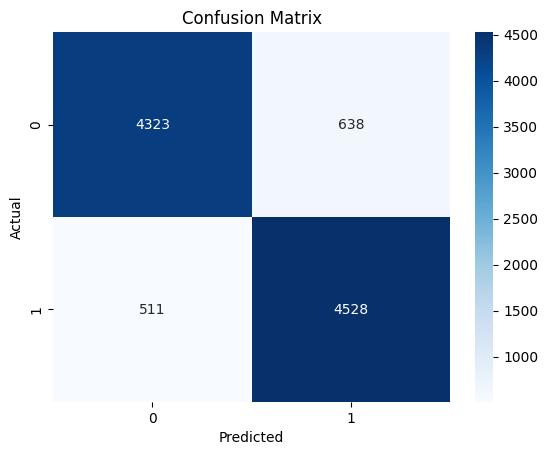

In [28]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Custom Prediction


In [39]:
def predict_sentiment(text):
    text = clean_text(text)
    vector = tfidf.transform([text])
    pred = model.predict(vector)[0]
    return "Positive " if pred == 1 else "Negative "

sample_text = "I absolutely loved this movie!"
print("Text:", sample_text)
print("Predicted Sentiment:", predict_sentiment(sample_text))

Text: I absolutely loved this movie!
Predicted Sentiment: Positive 
